<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'SiPM DST' Study</p><br>

# Prepares an analysis for fiber study from FLEX data

In [ ]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [ ]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [ ]:
from pynext.pynext_types import SiPM

In [ ]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

# Code

# DATA

In [7]:
VERBOSITY = False

# Input data

In [8]:
iPATH = "/Users/jj/Development/demoData/flexkr1ns"
file ='NEXT_FLEX.Kr83.ACTIVE.0.next.h5'
path =f'{iPATH}/{file}'

In [9]:
ifnames = glob.glob(f"{iPATH}/NEXT_FLEX.Kr83.ACTIVE*.h5")

if VERBOSITY:
    print(f"{len(ifnames)} input file names ...\n")
    for ifname in ifnames:
        print(ifname)
        #print(get_event_numbers_in_file(ifname))
else:
    print(f"{len(ifnames)} input file names ...\n")

249 input file names ...



In [10]:
# Verbosing main config parameters
mcConfig = load_mcconfiguration(ifnames[0])
mcConfig.set_index("param_key", inplace = True)
main_params = ["/Geometry/NextFlex/e_lifetime", "/Geometry/NextFlex/el_gap_length",
               "/Geometry/NextFlex/el_field_int", "/Geometry/NextFlex/tp_sipm_anode_dist",
               "/Geometry/NextFlex/tp_teflon_thickness", "/Geometry/NextFlex/tp_teflon_hole_diam",
               "/Geometry/NextFlex/tp_sipm_sizeX", "/Geometry/NextFlex/tp_sipm_pitchX",
               "num_events", "TP_SiPM_binning", "F_SENSOR_L_binning", "F_SENSOR_R_binning"]
print(mcConfig.loc[main_params])


                                                param_value
param_key                                                  
/Geometry/NextFlex/e_lifetime                     10000. ms
/Geometry/NextFlex/el_gap_length                    10.  mm
/Geometry/NextFlex/el_field_int             16. kilovolt/cm
/Geometry/NextFlex/tp_sipm_anode_dist              13.1  mm
/Geometry/NextFlex/tp_teflon_thickness               2.1 mm
/Geometry/NextFlex/tp_teflon_hole_diam               3.  mm
/Geometry/NextFlex/tp_sipm_sizeX                    1.0  mm
/Geometry/NextFlex/tp_sipm_pitchX                  15.55 mm
num_events                                              200
TP_SiPM_binning                                1.000000 mus
F_SENSOR_L_binning                             0.001000 mus
F_SENSOR_R_binning                             0.001000 mus


In [11]:
par = mcConfig.loc["/Geometry/NextFlex/tp_sipm_pitchX"]
par

param_value           15.55 mm
Name: /Geometry/NextFlex/tp_sipm_pitchX, dtype: object

## Extract pitch from params

In [12]:
pitch = float(par.param_value.split(' ')[-2])
pitch

15.55

## Sensors

In [13]:
get_sensor_binning(ifnames[0])

,bin_width
sns_name,
F_SENSOR_L,1.0
F_SENSOR_R,1.0
TP_SiPM,1000.0


In [14]:
sns_types = get_sensor_types(ifnames[0])
sns_types.head()

,sensor_id,sensor_name
0,100130,F_SENSOR_L
1,101065,F_SENSOR_L
2,101493,F_SENSOR_L
3,101517,F_SENSOR_L
4,101471,F_SENSOR_L


In [15]:
sns_positions = load_mcsensor_positions(ifnames[0])
sns_positions.head()

,sensor_id,sensor_name,x,y,z
0,100130,F_SENSOR_L,248.667206,425.691925,-30.299999
1,101065,F_SENSOR_L,-457.600677,-183.441086,-30.299999
2,101493,F_SENSOR_L,-103.480804,482.017334,-30.299999
3,101517,F_SENSOR_L,-56.016682,489.807251,-30.299999
4,101471,F_SENSOR_L,-146.135162,470.843414,-30.299999


## SENSORS RESPONSE

In [16]:
sns_response = load_mcsensor_response_df(path)
sns_response

charge      time
event_id sensor_id                  
0        100015          1   99285.0
         100015          1   99418.0
         100015          1   99441.0
         100015          1  100022.0
         100015          1  100545.0
...                    ...       ...
180      1387            1  819000.0
181      1387            1   89000.0
         1387            1   90000.0
         1387            1   93000.0
183      1387            1  990000.0

[11149046 rows x 2 columns]

In [17]:
sipm_index = 100000
fibers_response = sns_response[sns_response.index.get_level_values("sensor_id") >= sipm_index]

In [18]:
fibers_response

charge      time
event_id sensor_id                  
0        100015          1   99285.0
         100015          1   99418.0
         100015          1   99441.0
         100015          1  100022.0
         100015          1  100545.0
...                    ...       ...
199      201513          1  541884.0
         201513          1  542221.0
         201513          1  542693.0
         201513          1  543320.0
         201513          1  545392.0

[10964876 rows x 2 columns]

In [19]:
ifb = fibers_response.index

In [20]:
np.unique(fibers_response.index.get_level_values(1).values)

array([100000, 100001, 100002, ..., 201542, 201543, 201544], dtype=uint64)

In [58]:
evt = fibers_response.loc[1]
fi  = np.unique(evt.index.values)
fi

array([100000, 100001, 100002, ..., 201542, 201543, 201544], dtype=uint64)

In [59]:
len(fi)

3090

In [60]:
evt

,charge,time
sensor_id,,
100015,1,1061322.0
100015,1,1062742.0
100015,1,1062837.0
100015,1,1063175.0
100015,1,1063300.0
...,...,...
201513,1,1066751.0
201513,1,1068106.0
201513,1,1068378.0


In [41]:
evt.index

UInt64Index([100015, 100015, 100015, 100015, 100015, 100015, 100015, 100015,
             100015, 100015,
             ...
             200478, 200478, 201513, 201513, 201513, 201513, 201513, 201513,
             201513, 201513],
            dtype='uint64', name='sensor_id', length=55837)

In [42]:
grouped = evt.groupby(level=0)

In [64]:
fn = []
tmin = []
for fid, group in grouped:
    fn.append(fid)
    tmin.append(group['time'].min())

In [68]:
plt.hist(tmin[tmin>80000])

TypeError: '>' not supported between instances of 'list' and 'int'

In [ ]:
from ig in grouped.first()

In [28]:
fi[0]

100000

In [35]:
(evt.loc[100015].time).iloc[0] 

99285.0

In [40]:
evt.loc[100001].time - (evt.loc[100001].time).iloc[0] 

sensor_id
100001       0.0
100001       8.0
100001     462.0
100001     794.0
100001     945.0
100001    1329.0
100001    1583.0
100001    1732.0
100001    1803.0
100001    1902.0
100001    1966.0
100001    2403.0
100001    2655.0
100001    2722.0
100001    2914.0
100001    3454.0
100001    4789.0
Name: time, dtype: float64

In [70]:
def fibers_time_integral(fibers_response):
        grouped_multiple = fibers_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
        grouped_multiple.columns = ['tot_charge']
        return grouped_multiple.reset_index()


In [71]:
fti = fibers_time_integral(fibers_response)

In [72]:
fti

,event_id,sensor_id,tot_charge
0,0,100000,18
1,0,100001,17
2,0,100002,24
3,0,100003,19
4,0,100004,18
...,...,...,...
617989,199,201540,11
617990,199,201541,13
617991,199,201542,16
617992,199,201543,7


In [78]:
def fibers_time_min(fibers_response):
        grouped_multiple = fibers_response.groupby(['event_id', 'sensor_id']).agg({'time': ['min', 'max']})
        grouped_multiple.columns = ['min_time', 'max_time']
        return grouped_multiple.reset_index()


In [79]:
ftm = fibers_time_min(fibers_response)

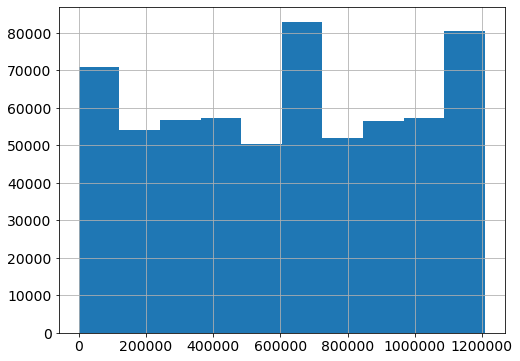

In [80]:
ftm['min_time'].hist()

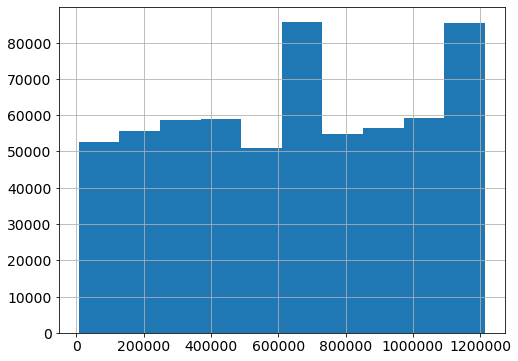

In [81]:
ftm['max_time'].hist()

In [82]:
ftm

,event_id,sensor_id,min_time,max_time
0,0,100000,98633.0,103301.0
1,0,100001,98624.0,103413.0
2,0,100002,98512.0,103847.0
3,0,100003,99142.0,103536.0
4,0,100004,97738.0,102636.0
...,...,...,...,...
617989,199,201540,539632.0,542615.0
617990,199,201541,537309.0,541981.0
617991,199,201542,536662.0,542937.0
617992,199,201543,537538.0,542299.0


In [24]:
def fiber_analysis(fiberdf, verbose=False, ic=100):
    
    def get_event_numbers():
        return np.unique(fiberdf.index.get_level_values(0).values)
    def get_fiber_numbers():
        return np.unique(evt.index.values)

    ii = 0
    for i in get_event_numbers():
        evt = fiberdf.loc[i]
        if len(evt) == 0:
            print(f' event = {ii} number = {i} is corrupted, skipping')
            continue

        if ii%ic == 0 and verbose:
            print(f' event number = {i}, index = {evt.index}')
            
        iii = 0
        for j in get_fiber_numbers():
            fiber = evt.loc[j]
            if ii%ic == 0 and iii < 10 and verbose:
                print(f' fiber = {j} charge = {fiber.charge}, time = {fiber.time}')
            iii+=1
        ii+=1
            


In [25]:
fiber_analysis(fibers_response, verbose=True, ic=100)

 event number = 0, index = UInt64Index([100015, 100015, 100015, 100015, 100015, 100015, 100015, 100015,
             100015, 100015,
             ...
             200478, 200478, 201513, 201513, 201513, 201513, 201513, 201513,
             201513, 201513],
            dtype='uint64', name='sensor_id', length=55837)
 fiber = 100000 charge = sensor_id
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
100000    1
Name: charge, dtype: uint32, time = sensor_id
100000     98633.0
100000     99873.0
100000     99969.0
100000    100055.0
100000    100458.0
100000    100948.0
100000    101039.0
100000    101475.0
100000    101488.0
100000    101516.0
100000    101778.0
100000    102133.0
100000    102151.0
100000    102509.0
100000    102603.0
100000    102776.0
100000    103249.0
100000    103301.0
Name: time, dtype: float64
 fiber = 100001 c

KeyboardInterrupt: 

In [ ]:
fevt0 = fibers_response.loc[0]

In [ ]:
fevt0

In [ ]:
f15 = fevt0.loc[100015]

In [ ]:
f15

In [ ]:
f15.plot(kind='scatter', x='charge', y='time')

In [ ]:
grouped_multiple = sipm_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
grouped_multiple.columns = ['tot_charge']
sipmdf = grouped_multiple.reset_index()
sipmdf


In [ ]:
sipm0 = sipmdf[sipmdf.event_id==0]
sipm0

In [ ]:
sipm0.tot_charge.max()

In [ ]:
sipmdf['tot_charge'].plot(kind='hist', color='blue')

In [ ]:
_, _, _ = plt.hist(sipmdf.groupby('sensor_id').tot_charge.max(), bins=50)

In [ ]:
true_positions['S1e'] = fibers_response[fibers_response.time < s1_time].groupby('event_id').charge.sum()
true_positions['S2e'] = fibers_response[fibers_response.time > s1_time].groupby('event_id').charge.sum()

In [ ]:
true_positions

In [ ]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S2e', cmap='viridis')

In [ ]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S1e', cmap='viridis')

In [ ]:
def kr_dst2(ifnames, sipm_map, key_sensor_fibres = 100000, s1_time = 1.*units.mus, verbose=False, ic=100):
    """Prepares an analysis dst for Krypton, including:
    
    1. True positions from the MC
    2. Computed positions from Barycenter (around SiPM with max charge) -- after integrating all time bins
    3. S1e from fibers --- MC response
    2. S2e from MC     --- MC response
    
    """
    
    def get_file_name(ifname):
        lname = ifname.split('.')
        t1 = ".".join(lname[1:-1])
        t = "".join([lname[0],t1])
        f =f"{t}.csv"
        return f

    def sipm_time_integral():
        grouped_multiple = sipm_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
        grouped_multiple.columns = ['tot_charge']
        return grouped_multiple.reset_index()
            
    def get_q(evt, ix):
        if ix != NN:
            q = evt[evt.sensor_id==ix].tot_charge.values[0]
        else:
            q = 0        
        return q
    
    def get_pos(vz, vq):
        return np.dot(vz, vq) / np.sum(vq) 
    
    def get_krdf():
      
        sipmdf = sipm_time_integral()
        
        if verbose:
            print(sipmdf)
        
        krdf = get_evt_true_positions_and_energy(mcParts)
        krdf['S1e'] = fibers_response[fibers_response.time < s1_time].groupby('event_id').charge.sum()
        krdf['S2e'] = fibers_response[fibers_response.time > s1_time].groupby('event_id').charge.sum()
        
        if verbose:
            print(krdf)

        xMax = []
        xPos = []
        yMax = []
        yPos = []

        qMax = []
        qL   = []
        qR   = []
        qU   = []
        qD   = []

        if verbose:
            print(krdf.index)
        
        ii = 0
        for i in krdf.index:
            if ii%ic == 0:
                print(f' event = {ii} event number = {i}')
            
            ii+=1

            evt          = sipmdf[sipmdf.event_id==i]
            qmax         = evt.tot_charge.max()
            iqmax        = evt[evt.tot_charge==qmax].sensor_id.values[0]

            qmaxdf       = sipm_map[sipm_map.sensor_id==iqmax]
            xqmax, yqmax =  qmaxdf.x.values[0], qmaxdf.y.values[0]
            xl, xr       =  qmaxdf.xl.values[0], qmaxdf.xr.values[0]
            yu, yd       =  qmaxdf.yu.values[0], qmaxdf.yd.values[0]

            ql = get_q(evt, qmaxdf.id_xl.values[0])
            qr = get_q(evt, qmaxdf.id_xr.values[0])
            qu = get_q(evt, qmaxdf.id_yu.values[0])
            qd = get_q(evt, qmaxdf.id_yd.values[0])

            xp = get_pos(np.array([xqmax, xl, xr]), np.array([qmax, ql, qr]))
            yp = get_pos(np.array([yqmax, yu, yd]), np.array([qmax, qu, qd]))

            xMax.append(xqmax)
            xPos.append(xp)
            yMax.append(yqmax)
            yPos.append(yp)
            qMax.append(qmax) 
            qL.append(ql)   
            qR.append(qr)   
            qU.append(qu)   
            qD.append(qd)   


        krdf['xmax'] = xMax
        krdf['ymax'] = yMax
        krdf['xpos'] = xPos
        krdf['ypos'] = yPos
        krdf['qmax'] = qMax
        krdf['ql']   = qL
        krdf['qr']   = qR
        krdf['qu']   = qU
        krdf['qd']   = qD

        return krdf, ii
    
    # Glue files
    
    GF =[]
    BF =[]
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        for ifname in ifnames:
            print(f'reading file {ifname}')
            
            try: 
                mcParts = load_mcparticles_df(ifname)
            except:
                print(f'Failed reading mcparticles ={ifname}')
                BF.append(ifname)
                continue
            
            try:
                sns_response = load_mcsensor_response_df(ifname)
            except:
                print(f'Failed reading sns_response ={ifname}')
                continue

            GF.append(ifname)
            fibers_response = sns_response[sns_response.index.get_level_values("sensor_id") >= key_sensor_fibres]
            sipm_response   = sns_response[sns_response.index.get_level_values("sensor_id") < key_sensor_fibres]
                                                          
            krdf, nof = get_krdf()
            file = get_file_name(ifname)
            print(f'saving file {file}, with {nof} events')
            krdf.to_csv(file)

    return GF, BF, nof, krdf
        

In [ ]:
gf, bf, nof, krdf = kr_dst2(['/Users/jj/Development/demoData/flex/NEXT_FLEX.Kr83.ACTIVE.0.next.h5'], 
                            sipm_map, key_sensor_fibres = 100000, s1_time = 1.*units.mus, verbose=False, ic=100)

In [ ]:
krdf

In [ ]:
def kr_join_dst(ifnames, verbose=False, ic=100):
    """Joins the csv dst files
        
    """
    
    krdst           = pd.DataFrame()
    BF =[]
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        for ifname in ifnames:
            if verbose:
                print(f'reading file {ifname}')
            try: 
                kdst = pd.read_csv(ifname)
            except:
                print(f'Failed reading csv dst file ={ifname}')
                BF.append(ifname)
                continue
            
            if verbose:
                print(kdst)
            krdst = krdst.append(kdst)
            
    return krdst, BF


        
        

In [ ]:
ifnames = glob.glob(f"{iPATH}/NEXT_FLEXKr83.ACTIVE.3*.csv")

In [ ]:
ifnames

In [ ]:
krdst, BF = kr_join_dst(ifnames, verbose=False)

In [ ]:
krdst

In [ ]:
krdst = pd.read_csv('/Users/jj/Development/demoData/flex/krdf_1.csv')

In [ ]:
def sigma_max_true(krdst, true='true_x', var='xmax', bins=10, alpha=0.6, color='g'):
    dx = (krdst[true] - krdst[var]).values
    mu, std = norm.fit(dx)
    plt.hist(dx, bins=bins, density=True, alpha=alpha, color=color)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()
    

In [ ]:
sigma_max_true(krdst, true='true_x', var='xmax', bins=100, alpha=0.6, color='g')

In [ ]:
sigma_max_true(krdst, true='true_x', var='xpos', bins=100, alpha=0.6, color='g')

In [ ]:
sigma_max_true(krdst, true='true_y', var='ypos', bins=100, alpha=0.6, color='g')

In [ ]:
krdst.plot(kind='scatter', x='xpos', y='ypos', c='S2e', cmap='viridis')

In [ ]:
krdst.plot(kind='scatter', x='xmax', y='ymax', c='S2e', cmap='viridis')

In [ ]:
krdst.plot(kind='scatter', x='true_x', y='true_y', c='S2e', cmap='viridis')

In [ ]:
krdst['S2e'].plot(kind='hist', bins=100, color='blue')

In [ ]:
krdst['qmax'].plot(kind='hist', bins=100, color='blue')

In [ ]:
krdst[['qu','qd','ql','qr']].plot(kind='hist', bins=50)

In [ ]:
def histo_s1(s1fid = 200, bins=100, alpha=0.6, color='g'):
    
    s1df = krdst[krdst.S1e < s1fid]
    plt.hist(s1df.S1e.values, bins=bins, density=True, alpha=alpha, color=color)
    plt.show()


In [ ]:
histo_s1()

In [83]:
100 / 3100

0.03225806451612903